2025-05-10 15:42:21.998 
  command:

    streamlit run C:\Anaconda\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
C:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


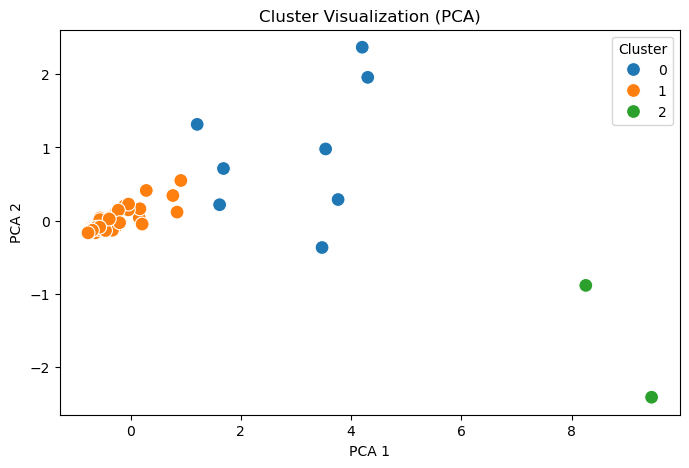

In [1]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ตั้งค่าหน้าเว็บ
st.set_page_config(page_title="Flight Route Clustering", layout="wide")

# โหลดข้อมูล (เปลี่ยน path ถ้าจำเป็น)
df = pd.read_csv("Air_Traffic_Passenger_Statistics.csv")

# แปลงวันที่
df['Activity Period'] = pd.to_datetime(df['Activity Period'], errors='coerce', format='%Y%m')
df = df.dropna(subset=["Activity Period"])

# สร้าง Year, Month, Route
df['Year'] = df['Activity Period'].dt.year
df['Month'] = df['Activity Period'].dt.month
df['Route'] = df['Operating Airline'] + " to " + df['GEO Region']

# ดึงข้อมูลเฉพาะที่ต้องใช้
st.title("✈️ Flight Route Clustering for Optimization")

# Sidebar
with st.sidebar:
    st.header("🔧 Clustering Configuration")
    k = st.slider("Select number of clusters (k)", 2, 10, 3)

# รวมข้อมูลต่อ route
route_group = df.groupby("Route").agg(
    avg_passenger_per_month=("Passenger Count", "mean"),
    std_passenger=("Passenger Count", "std"),
    total_passenger=("Passenger Count", "sum")
).reset_index()

# ลบค่าขาดหาย
route_group.dropna(inplace=True)

# ทำ Standardize ข้อมูลก่อน Clustering
features = ['avg_passenger_per_month', 'std_passenger', 'total_passenger']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(route_group[features])

# ทำ KMeans
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
route_group['Cluster'] = kmeans.fit_predict(X_scaled)

# PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
route_group['PCA1'] = pca_result[:, 0]
route_group['PCA2'] = pca_result[:, 1]

# แสดงผล
st.subheader("📊 Clustered Flight Routes")
st.dataframe(route_group[['Route', 'avg_passenger_per_month', 'std_passenger', 'total_passenger', 'Cluster']])

# กราฟ Scatter Plot
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=route_group, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=100)
plt.title("Cluster Visualization (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
st.pyplot(fig)
